# Differential evolution: extensive testing on toy problems

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.functionaltests.differential_evolution_mcmc as de

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [2]:
t = pints.Timer()
test = run_replicates(np.geomspace(2000, 20000, 8), 10, de.two_dim_gaussian, parallel)
print(t.format())

1 minute, 1 second


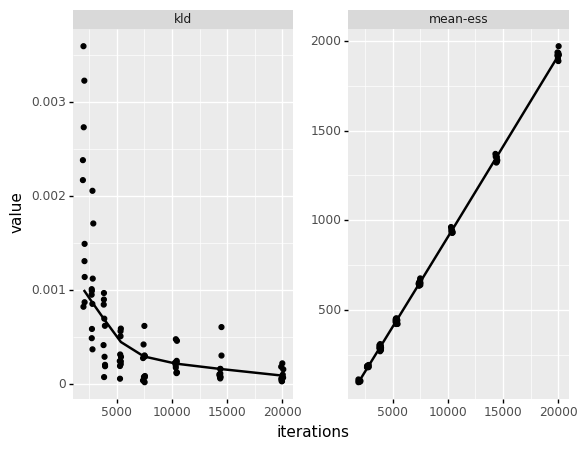

<ggplot: (8783812127220)>

In [3]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions.

In the next cell, we show the trace for an example run.

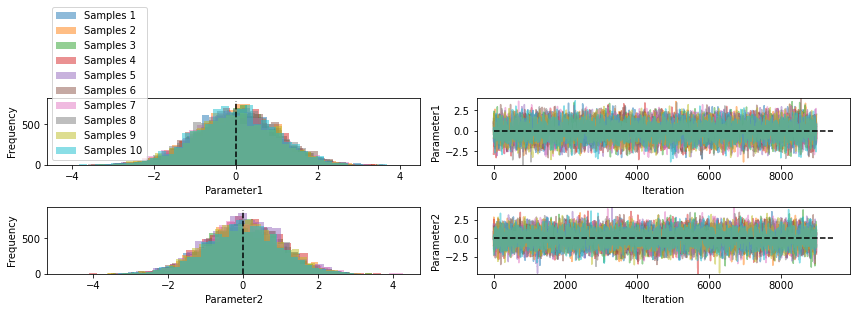

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  -0.00   1.00    -1.98   -0.67  0.00   0.67   1.96     1.00    8648.18  1415.73
param 2  0.01    1.01    -1.98   -0.65  0.01   0.69   2.00     1.00    8757.79  1433.67


In [4]:
n_chains = 10
n_iterations = 10000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

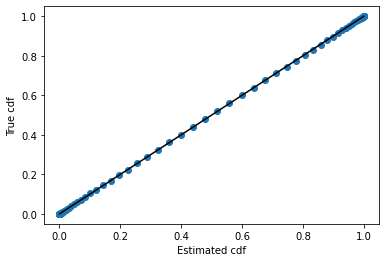

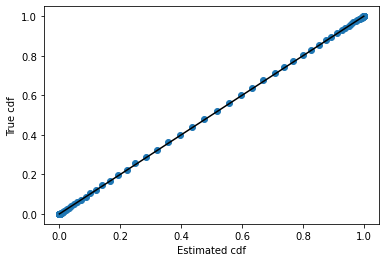

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

The parameter results and CDFs both look close to their true values.

# Correlated Gaussian

In [6]:
t = pints.Timer()
test = run_replicates(np.geomspace(5000, 20000, 8), 10, de.correlated_gaussian, parallel)
print(t.format())

3 minutes, 7 seconds


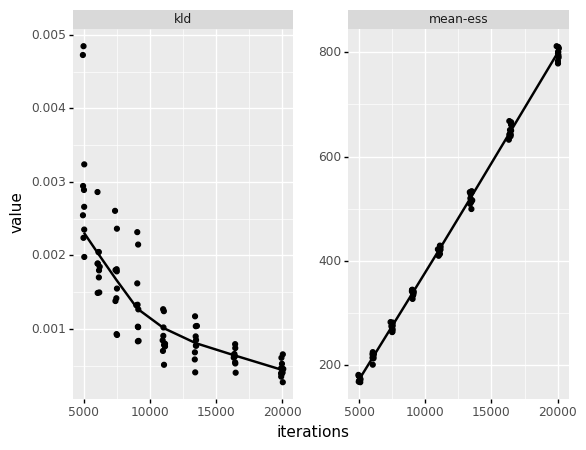

<ggplot: (8783798133944)>

In [7]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions. Below, we look at an example run of results.

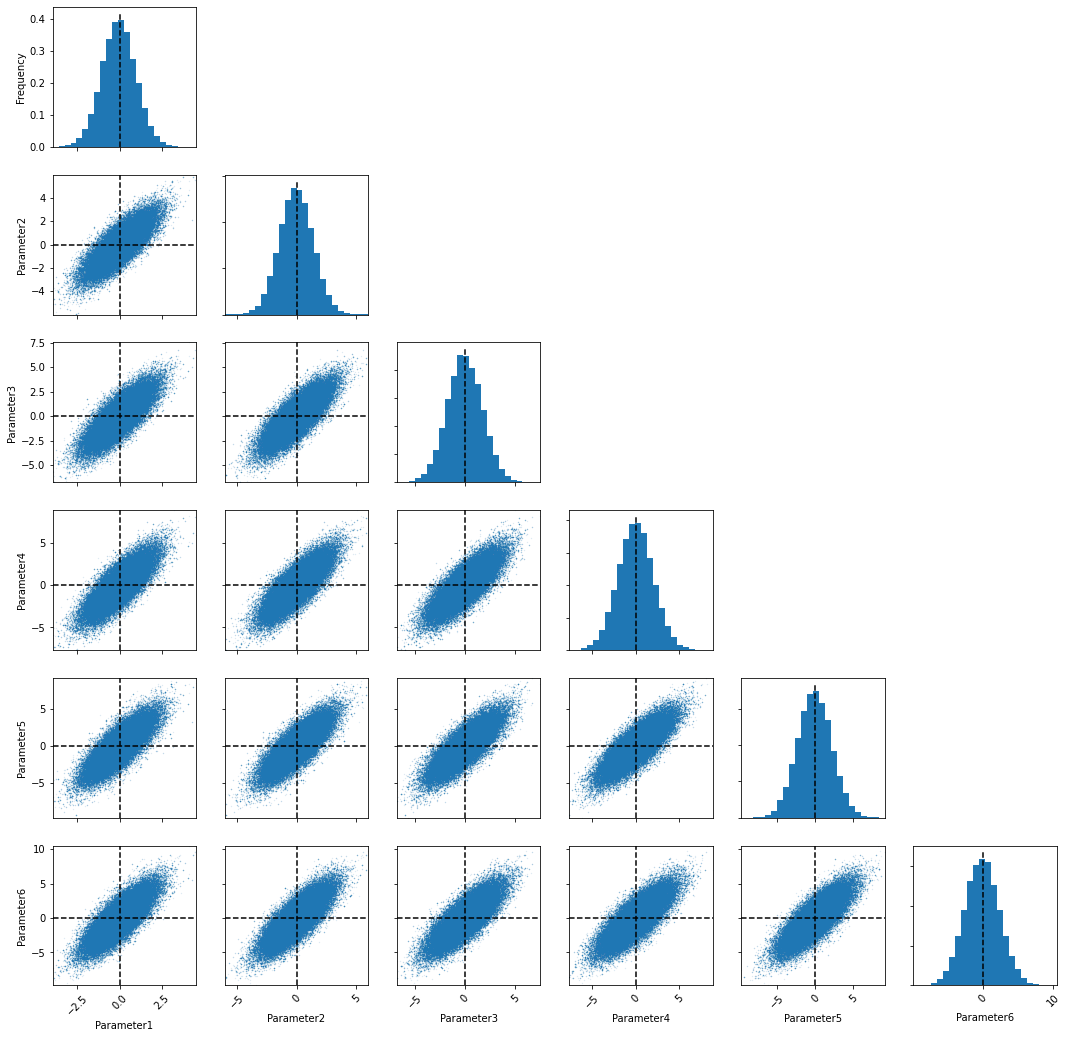

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  -0.02   1.00    -1.98   -0.70  -0.02  0.64   1.94     1.00    7663.34  640.06
param 2  -0.02   1.41    -2.77   -0.99  -0.03  0.94   2.76     1.00    7828.60  653.87
param 3  -0.03   1.73    -3.42   -1.21  -0.05  1.16   3.35     1.00    7528.50  628.80
param 4  -0.03   2.01    -3.98   -1.38  -0.03  1.31   3.96     1.00    7832.97  654.23
param 5  -0.06   2.25    -4.46   -1.57  -0.07  1.48   4.34     1.00    7615.24  636.05
param 6  -0.05   2.44    -4.79   -1.71  -0.04  1.59   4.78     1.00    7752.39  647.50


In [8]:
n_chains = 20
n_iterations = 10000
n_warmup = 1000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

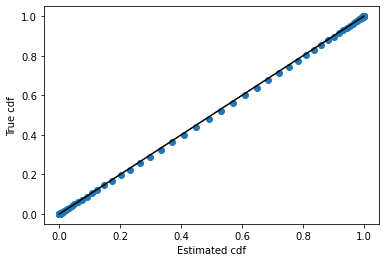

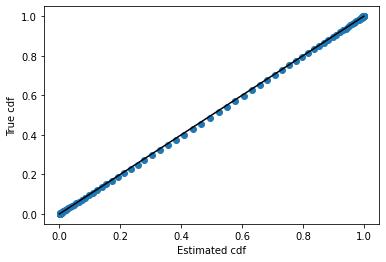

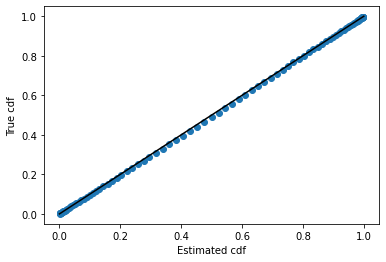

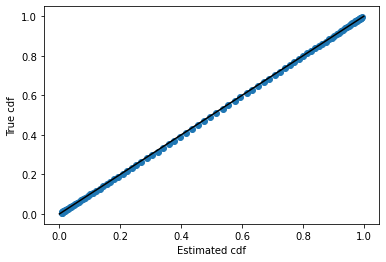

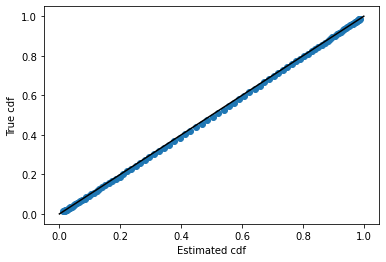

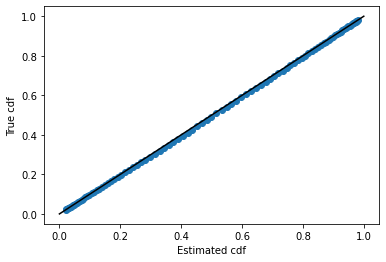

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

The CDFs are accurate and the shape of the distribution is captured correctly.

# Banana

In [10]:
t = pints.Timer()
test = run_replicates(np.geomspace(2000, 20000, 8), 10, de.banana, parallel)
print(t.format())

2 minutes, 18 seconds


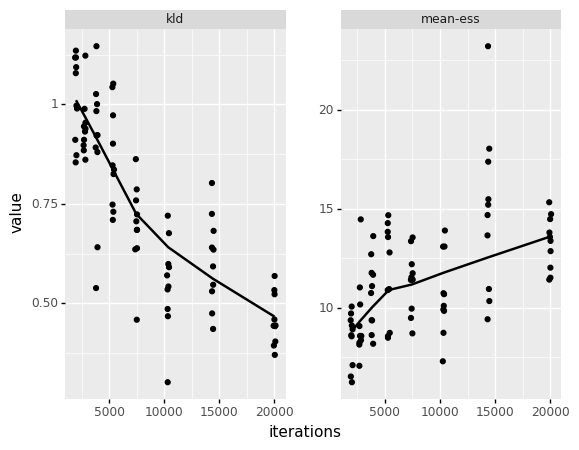

<ggplot: (8783798786024)>

In [11]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Due to the difficuty of the problem, the results are more noisy and the values of ESS are lower than before. However, the trend is still in the correct direction.

Example run of results.

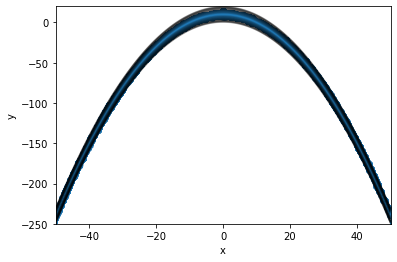

In [12]:
n_chains = 20
n_iterations = 20000
n_warmup = 1000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-250, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2, linestyles='-')
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.05)
plt.xlim(-50, 50)
plt.ylim(-250, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [13]:
t = pints.Timer()
test = run_replicates(np.geomspace(3000, 20000, 8), 10, de.annulus, parallel)
print(t.format())

2 minutes, 57 seconds


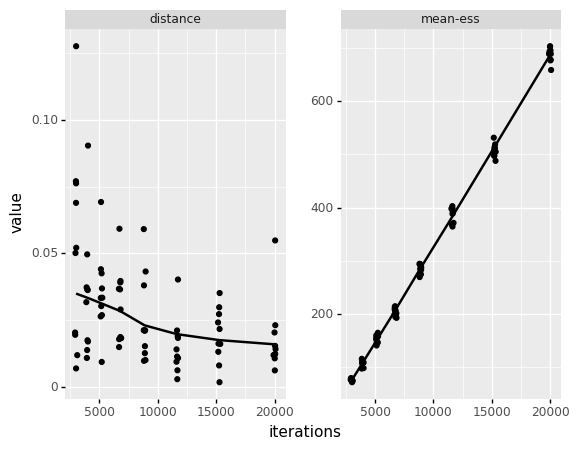

<ggplot: (8783812134488)>

In [14]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The distance and ESS both show expected performance on this problem.

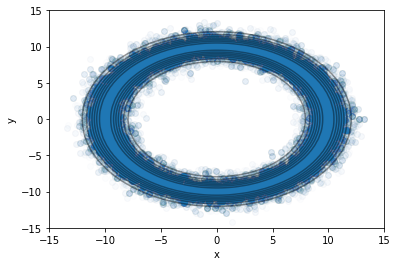

In [15]:
n_chains = 10
n_iterations = 10000
n_warmup = 1000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.DifferentialEvolutionMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.show()